In [5]:
#Importing Libraries
#Data Handling
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys
sys.path.append('../../')

#Pipelines
from source import *
import source.pipes as op
from source.estimators import FORESEE

#Storing trains
import pickle

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Computing True Risk

## Create the computation for the true risk

In [127]:
X1 = np.array([random.randint(0,10000)/10000 for x in range(5000)])
X2 = np.array([random.randint(0,10000)/10000 for x in range(5000)])
gamma = (X1+X2)/2

S = np.ones(5000, dtype=int)

Y = np.ones(5000, dtype=int)

data_f = pd.concat([pd.DataFrame(X1), pd.DataFrame(X2), pd.DataFrame(S), pd.DataFrame(Y), pd.DataFrame(gamma)], axis = 1)
cols = ['col_'+str(i) for i in range(2)]
cols.append('S')
cols.append('Y')
cols.append('gamma')
data_f.columns = cols


In [133]:
#Define functions to make replications
def makeCopies(X, y, s, gamma, n_copies):
    X_final = X.copy()
    s_final = s.copy()
    y_final = y.copy()
    gamma_final = gamma.copy()
    
    #copies with original s
    for i in range(n_copies-1):
        X_final = np.concatenate((X_final, X.copy()), axis= 0)
        s_final = np.concatenate((s_final, s), axis = 0)
        y_final = np.concatenate((y_final, y.copy()), axis=0)
        gamma_final = np.concatenate((gamma_final, gamma.copy()), axis=0)
    
    #copies with S flipped
    for i in range(n_copies):
        X_final = np.concatenate((X_final, X.copy()), axis= 0)
        s_final = np.concatenate((s_final, 1-s), axis = 0)
        y_final = np.concatenate((y_final, y.copy()), axis=0)
        gamma_final = np.concatenate((gamma_final, gamma.copy()), axis=0)
    
    return X_final, s_final, y_final, gamma_final
    
def createSynthetic(X, y, s, gamma, n_copies):
    X_copy, s_copy, y_copy, gamma_final = makeCopies(X,y,s,gamma, n_copies)
    mid = int((X_copy.shape[0]/2))
    
    for i in range(mid, X_copy.shape[0]):
        y_copy[i] = np.random.choice([0,1], size=1, p = [gamma_final[i],1-gamma_final[i]])
        
    return X_copy, s_copy, y_copy

def computeRisk(X, S, Y):
    risk = np.zeros((X.shape[0]))
    for x in range(X.shape[0]):
        s_x = S[x]
        dim1 = X[x,0]
        dim2 = X[x,1]
        risk[x] = abs(Y[(S==s_x) & (X[:,0]==dim1) & (X[:,1]==dim2)].mean()-
                      Y[(S==1-s_x) & (X[:,0]==dim1) & (X[:,1]==dim2)].mean())
    return risk

In [136]:
X_final, S_final, Y_final = createSynthetic(X = np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)), axis=1),
                                             y = Y,
                                             s = S,
                                             gamma = gamma,
                                             n_copies = 10)

In [137]:
risk = computeRisk(X_final, S_final, Y_final)

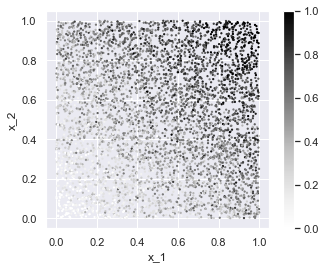

In [5]:
plt.figure(figsize=(5, 4))
plt.scatter(X_final[:5000,0], X_final[:5000,1], c=risk[:5000], s=1.5, cmap='Greys')
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.colorbar()
plt.show()

In [28]:
with open('checkpoints/synthetic_data.pickle', 'wb') as f:
    pickle.dump(data_f, f)

with open('checkpoints/synthetic_data_risk.pickle', 'wb') as f:
    pickle.dump(risk, f)
    
with open('checkpoints/synthetic_data_X_final.pickle', 'wb') as f:
    pickle.dump(X_final, f)
    
with open('checkpoints/synthetic_data_X_final.pickle', 'wb') as f:
    pickle.dump(X_final, f)   
    
with open('checkpoints/synthetic_data_Y_final.pickle', 'wb') as f:
    pickle.dump(Y_final, f)    
    
with open('checkpoints/synthetic_data_S_final.pickle', 'wb') as f:
    pickle.dump(S_final, f)

In [2]:
data_f = op.import_pickle('checkpoints/synthetic_data.pickle')
risk = op.import_pickle('checkpoints/synthetic_data_risk.pickle')
X_final = op.import_pickle('checkpoints/synthetic_data_X_final.pickle')
Y_final = op.import_pickle('checkpoints/synthetic_data_Y_final.pickle')    
S_final = op.import_pickle('checkpoints/synthetic_data_S_final.pickle')

In [3]:
#Split the dataset into train and test
def splitTrainTest(X_final, S_final, Y_final, risk):
    dataset = np.concatenate((X_final, S_final.reshape(-1,1), risk.reshape(-1,1)), axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(dataset, Y_final, test_size = 0.3, stratify= Y_final, random_state = 1)

    S_train = X_train[:,2]
    S_test = X_test[:,2]
    risk_train = X_train[:,-1]
    risk_test = X_test[:,-1]
    X_train = X_train[:,:2]
    X_test = X_test[:,:2]
    
    return X_train, S_train, y_train, risk_train, X_test, S_test, y_test, risk_test


In [6]:
X_train, S_train, y_train, risk_train, X_test, S_test, y_test, risk_test = splitTrainTest(X_final=X_final,
                                                                                         S_final=S_final,
                                                                                         Y_final=Y_final,
                                                                                         risk = risk)

In [12]:
ds_train = {'X': X_train,
           'S':S_train, 
           'y':y_train,
           'risk':risk_train}

ds_test = {'X': X_test, 
           'S':S_test, 
           'y':y_test,
           'risk':risk_test}

In [13]:
with open('checkpoints/synthetic_data_train.pickle', 'wb') as f:
    pickle.dump(ds_train, f)
    
with open('checkpoints/synthetic_data_test.pickle', 'wb') as f:
    pickle.dump(ds_test, f)

In [14]:
ds_test = op.import_pickle('checkpoints/synthetic_data_test.pickle')

X_test = ds_test['X']
S_test = ds_test['S']
y_test = ds_test['y']
risk_test = ds_test['risk']

ds_train = op.import_pickle('checkpoints/synthetic_data_train.pickle')

X_train = ds_train['X']
S_train = ds_train['S']
y_train = ds_train['y']
risk_train = ds_train['risk']


# Foresee Algorithm

In [15]:
fsee= FORESEE(min_samples_leaf=[2])

fsee.fit(X=X_train,
         A=S_train,
         priv_class=1,
         y=y_train,
         k=200,
         scoring=['accuracy'])


Complete                    

In [16]:
estimated_risk_train, disc_acc_train, count_disc_train = fsee.risk_disc(X=X_train,
                                                                        y=y_train,
                                                                        A=S_train,
                                                                        priv_class=1, 
                                                                        alpha=0.0, 
                                                                        beta=0.0)


In [17]:
estimated_risk_test, disc_acc_test, count_disc_test = fsee.risk_disc(X=X_test,
                                                            y=y_test,
                                                            A=S_test,
                                                            priv_class=1, 
                                                            alpha=0.0, 
                                                            beta=0.0)


In [54]:
with open('checkpoints/fsee.pickle', 'wb') as f:
    pickle.dump(fsee, f, protocol = pickle.HIGHEST_PROTOCOL)

with open('checkpoints/estimated_risk_train.pickle', 'wb') as f:
    pickle.dump(estimated_risk_train, f, protocol = pickle.HIGHEST_PROTOCOL)
    
with open('checkpoints/estimated_risk_test.pickle', 'wb') as f:
    pickle.dump(estimated_risk_test, f, protocol = pickle.HIGHEST_PROTOCOL)

In [6]:
fsee = op.import_pickle('checkpoints/fsee.pickle')
estimated_risk_train = op.import_pickle('checkpoints/estimated_risk_train.pickle')
estimated_risk_test = op.import_pickle('checkpoints/estimated_risk_test.pickle')

# S-BART

In [38]:
from bartpy.sklearnmodel import SklearnModel


In [39]:
#Training s-models
s_learners = {}

X_train_treated = np.append(X_train, S_train.reshape(-1,1), axis=1)
bart_model = SklearnModel() 
bart_model.fit(X_train_treated, y=y_train)


Starting burn
Starting burn


  0%|          | 0/200 [00:00<?, ?it/s]

Starting burn


  0%|          | 0/200 [00:00<?, ?it/s]

Starting burn


  0%|          | 0/200 [00:00<?, ?it/s]

Starting sampling


  0%|          | 0/200 [00:00<?, ?it/s] 1.19s/it]

Starting sampling


  0%|          | 0/200 [00:00<?, ?it/s]

Starting sampling


  0%|          | 0/200 [00:00<?, ?it/s]

Starting sampling


100%|██████████| 200/200 [04:23<00:00,  1.32s/it]


SklearnModel()

In [53]:
with open('checkpoints/bart_model.pickle', 'wb') as f:
    pickle.dump(bart_model, f, protocol = pickle.HIGHEST_PROTOCOL)
    

In [10]:
bart_model = op.import_pickle('checkpoints/bart_model.pickle')

In [41]:
#Predict ATE
X_test_treated = np.append(X_test, S_test.reshape(-1,1), axis=1)
risk_treated = bart_model.predict(X_test_treated)
X_test_changed = np.append(X_test, 1-S_test.reshape(-1,1), axis=1)
risk_not_treated = bart_model.predict(X_test_changed)
risk_BART = abs(risk_treated-risk_not_treated)

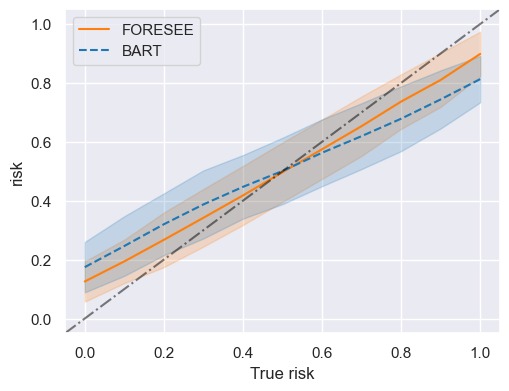

In [68]:
mean_BART = []
std_BART = []
mean_FORESEE = []
std_FORESEE = []

sns.set()

for r in np.unique(risk_test):
    risks = risk_BART[np.where(risk_test==r)]
    mean_BART.append(risks.mean())
    std_BART.append(risks.std())

    risks = estimated_risk_test['th_both'][np.where(risk_test==r)]
    mean_FORESEE.append(risks.mean())
    std_FORESEE.append(risks.std())

mean_BART = np.array(mean_BART)
std_BART = np.array(std_BART)
mean_FORESEE = np.array(mean_FORESEE)
std_FORESEE = np.array(std_FORESEE)
risks = np.unique(risk_test)

plt.figure(figsize=(5, 4))
plt.plot(risks, mean_FORESEE, c='tab:orange', linestyle='solid', label = 'FORESEE')
plt.plot(risks, mean_BART, c='tab:blue', linestyle='dashed', label = 'BART')
plt.fill_between(risks, mean_FORESEE+std_FORESEE, mean_FORESEE-std_FORESEE, alpha=0.2, color='tab:orange')
plt.fill_between(risks, mean_BART+std_BART, mean_BART-std_BART, alpha=0.2, color='tab:blue')

plt.xlabel('True risk')
plt.ylabel('risk')
plt.ylim([-0.05,1.05])
plt.xlim([-0.05,1.05])
plt.legend()
plt.axline((0,0), (1,1), color='black', label='ground truth', alpha=0.5, linestyle='dashdot')

plt.show()